###Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Since we've shared this drive with you, please use the correct file path from your drive since it'll go to SharedDrive for you
%cd '/content/drive/MyDrive/vqa'

/content/drive/MyDrive/vqa


In [5]:
import os
os.chdir("/content/drive/MyDrive/vqa")
#os.chdir("./")

###Import relevant libraries

In [3]:
!pip install opencv-python

In [4]:
import os
import numpy as np
import torch
import torchvision.models as models
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import re
import time
import cv2
import warnings

###Setting the constants and parameter values

In [7]:
input_dir = '/content/drive/MyDrive/vqa/input_dir'
log_dir = '/content/drive/MyDrive/vqa/logs'
model_dir = '/content/drive/MyDrive/vqa/models'

# maximum length of question, the length in the VQA dataset is 26
max_qst_length = 30
# maximum number of answers
max_num_ans = 10
# embedding size of feature vector for image and question
embed_size = 1024
# embedding size of the word used as the input for the LSTM
word_embed_size = 300
# Number of layers in the LSTM
num_layers = 2
# Hidden size in the LSTM
hidden_size = 64
# Learning rate, step size and decay rate used while initializing the Step learning rate Scheduler
learning_rate = 0.001
step_size = 10
gamma = 0.1
#Number of epochs it is trained on
num_epochs = 30
#Batch size, number of workers and the steps after which the model parameters are saved
batch_size = 256
num_workers = 4
save_step = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###Helper Functions for Handling Text

In [8]:
SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')

# create tokens
def tokenize(sentence):
    tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
    tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
    return tokens

# returns a file as list of lines
def load_str_list(fname):
    with open(fname) as f:
        lines = f.readlines()
    lines = [l.strip() for l in lines]
    return lines


# Tokenizes the text and then gives the index of the word from the vocab txt file of answers and questions
class VocabDict:

    def __init__(self, vocab_file):
        self.word_list = load_str_list(vocab_file)
        self.word2idx_dict = {w:n_w for n_w, w in enumerate(self.word_list)}
        self.vocab_size = len(self.word_list)
        self.unk2idx = self.word2idx_dict['<unk>'] if '<unk>' in self.word2idx_dict else None

    def idx2word(self, n_w):

        return self.word_list[n_w]

    def word2idx(self, w):
        if w in self.word2idx_dict:
            return self.word2idx_dict[w]
        elif self.unk2idx is not None:
            return self.unk2idx
        else:
            raise ValueError('word %s not in dictionary (while dictionary does not contain <unk>)' % w)

    def tokenize_and_index(self, sentence):
        inds = [self.word2idx(w) for w in tokenize(sentence)]

        return inds


###Building the Dataset and DataLoader

In [9]:
class VqaDataset(data.Dataset):

    def __init__(self, input_dir, input_vqa, max_qst_length=30, max_num_ans=10, transform=None):
        self.input_dir = input_dir
        self.vqa = np.load(input_dir+'/'+input_vqa, allow_pickle=True)
        self.qst_vocab = VocabDict(input_dir+'/dataset/vocab_questions.txt')
        self.ans_vocab = VocabDict(input_dir+'/dataset/vocab_answers.txt')
        self.max_qst_length = max_qst_length
        self.max_num_ans = max_num_ans
        self.load_ans = ('valid_answers' in self.vqa[0]) and (self.vqa[0]['valid_answers'] is not None)
        self.transform = transform

    def __getitem__(self, idx):

        vqa = self.vqa
        qst_vocab = self.qst_vocab
        ans_vocab = self.ans_vocab
        max_qst_length = self.max_qst_length
        max_num_ans = self.max_num_ans
        transform = self.transform
        load_ans = self.load_ans

        image = vqa[idx]['image_path']
        image = Image.open(image).convert('RGB')
        qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)  # padded with '<pad>' in 'ans_vocab'
        qst2idc[:len(vqa[idx]['question_tokens'])] = [qst_vocab.word2idx(w) for w in vqa[idx]['question_tokens']]
        sample = {'image': image, 'question': qst2idc}

        if load_ans:
            ans2idc = [ans_vocab.word2idx(w) for w in vqa[idx]['valid_answers']]
            ans2idx = np.random.choice(ans2idc)
            sample['answer_label'] = ans2idx         # for training

            mul2idc = list([-1] * max_num_ans)       # padded with -1 (no meaning) not used in 'ans_vocab'
            mul2idc[:len(ans2idc)] = ans2idc         # our model should not predict -1
            sample['answer_multi_choice'] = mul2idc  # for evaluation metric

        if transform:
            sample['image'] = transform(sample['image'])

        return sample

    def __len__(self):

        return len(self.vqa)


def get_loader(input_dir, input_vqa_train, input_vqa_valid, max_qst_length, max_num_ans, batch_size, num_workers):

    transform = {
        phase: transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406),
                                                        (0.229, 0.224, 0.225))])
        for phase in ['train', 'valid']}

    vqa_dataset = {
        'train': VqaDataset(
            input_dir=input_dir,
            input_vqa=input_vqa_train,
            max_qst_length=max_qst_length,
            max_num_ans=max_num_ans,
            transform=transform['train']),
        'valid': VqaDataset(
            input_dir=input_dir,
            input_vqa=input_vqa_valid,
            max_qst_length=max_qst_length,
            max_num_ans=max_num_ans,
            transform=transform['valid'])}

    data_loader = {
        phase: torch.utils.data.DataLoader(
            dataset=vqa_dataset[phase],
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers)
        for phase in ['train', 'valid']}

    return data_loader

In [10]:
from data_loader import VqaDataset,get_loader

##Model: Image Encoding Block

In [11]:
class ImgAttentionEncoder(nn.Module):

    def __init__(self, embed_size):

        super(ImgAttentionEncoder, self).__init__()
        vggnet_feat = models.vgg19(pretrained=True).features
        modules = list(vggnet_feat.children())[:-2]
        self.cnn = nn.Sequential(*modules)
        self.fc = nn.Sequential(nn.Linear(self.cnn[-3].out_channels, embed_size),
                                nn.Tanh())     # feature vector of image

    def forward(self, image):

        with torch.no_grad():
            img_feature = self.cnn(image)
        #print(img_feature.shape)                       # [batch_size, vgg16(19)_fc=4096]
        img_feature = img_feature.view(-1, 512, 196).transpose(1,2) # [batch_size, 196, 512]
        img_feature = self.fc(img_feature)                          # [batch_size, 196, embed_size]
        #print(image.shape, img_feature.shape,"\n")

        return img_feature



###Model: Question Encoding Block

In [12]:
class QstEncoder(nn.Module):

    def __init__(self, qst_vocab_size, word_embed_size, embed_size, num_layers, hidden_size):

        super(QstEncoder, self).__init__()
        self.word2vec = nn.Embedding(qst_vocab_size, word_embed_size)
        self.tanh = nn.Tanh()
        self.lstm = nn.LSTM(word_embed_size, hidden_size, num_layers)
        self.fc = nn.Linear(2*num_layers*hidden_size, embed_size)     # 2 for hidden and cell states

    def forward(self, question):

        qst_vec = self.word2vec(question)                             # [batch_size, max_qst_length=30, word_embed_size=300]
        qst_vec = self.tanh(qst_vec)
        qst_vec = qst_vec.transpose(0, 1)                             # [max_qst_length=30, batch_size, word_embed_size=300]
        _, (hidden, cell) = self.lstm(qst_vec)                        # [num_layers=2, batch_size, hidden_size=512]
        qst_feature = torch.cat((hidden, cell), 2)                    # [num_layers=2, batch_size, 2*hidden_size=1024]
        qst_feature = qst_feature.transpose(0, 1)                     # [batch_size, num_layers=2, 2*hidden_size=1024]
        qst_feature = qst_feature.reshape(qst_feature.size()[0], -1)  # [batch_size, 2*num_layers*hidden_size=2048]
        qst_feature = self.tanh(qst_feature)
        qst_feature = self.fc(qst_feature)                            # [batch_size, embed_size]

        return qst_feature

###Model: Attention Block

In [13]:
class Attention(nn.Module):
    def __init__(self, num_channels, embed_size, dropout=True):

        super(Attention, self).__init__()
        self.ff_image = nn.Linear(embed_size, num_channels)
        self.ff_questions = nn.Linear(embed_size, num_channels)
        self.dropout = nn.Dropout(p=0.5)
        self.ff_attention = nn.Linear(num_channels, 1)

    def forward(self, vi, vq):

        hi = self.ff_image(vi)
        hq = self.ff_questions(vq).unsqueeze(dim=1)
        ha = torch.tanh(hi+hq)
        if self.dropout:
            ha = self.dropout(ha)
        ha = self.ff_attention(ha)
        pi = torch.softmax(ha, dim=1)
        self.pi = pi
        vi_attended = (pi * vi).sum(dim=1)    # creating the weighted image vector using attention distribution
        u = vi_attended + vq      # concatenating the new query vector and the weighted image vector
        return u

###Model: Combine Image Encoding and Question Encoding Block

In [14]:
class SANModel(nn.Module):
    def __init__(self, embed_size, qst_vocab_size, ans_vocab_size, word_embed_size, num_layers, hidden_size):
        super(SANModel, self).__init__()
        self.num_attention_layer = 2
        self.num_mlp_layer = 1
        self.img_encoder = ImgAttentionEncoder(embed_size)
        self.qst_encoder = QstEncoder(qst_vocab_size, word_embed_size, embed_size, num_layers, hidden_size)
        self.san = nn.ModuleList([Attention(512, embed_size)]*self.num_attention_layer)
        self.tanh = nn.Tanh()
        self.mlp = nn.Sequential(nn.Dropout(p=0.5),
                            nn.Linear(embed_size, ans_vocab_size))
        self.attn_features = []  ## attention features

    def forward(self, img, qst):

        img_feature = self.img_encoder(img)                     # [batch_size, embed_size]
        qst_feature = self.qst_encoder(qst)                     # [batch_size, embed_size]
        vi = img_feature
        u = qst_feature
        for attn_layer in self.san:
            u = attn_layer(vi, u)

        combined_feature = self.mlp(u)
        return combined_feature

###Training Loop

In [15]:
# Get data loader for train and test - it's a dictionary with the key train having the train dataloader and same for test
data_loader = get_loader(
        input_dir=input_dir,
        input_vqa_train='train.npy',
        input_vqa_valid='valid.npy',
        max_qst_length=max_qst_length,
        max_num_ans=max_num_ans,
        batch_size=batch_size,
        num_workers=num_workers)

qst_vocab_size = data_loader['train'].dataset.qst_vocab.vocab_size
ans_vocab_size = data_loader['train'].dataset.ans_vocab.vocab_size
ans_unk_idx = data_loader['train'].dataset.ans_vocab.unk2idx

# Initializing the model
model = SANModel(
        embed_size=embed_size,
        qst_vocab_size=qst_vocab_size,
        ans_vocab_size=ans_vocab_size,
        word_embed_size=word_embed_size,
        num_layers=num_layers,
        hidden_size=hidden_size).to(device)

# Initializing the loss function
criterion = nn.CrossEntropyLoss()

# Initializing the optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


last_time = 0
early_stop_threshold = 3
best_loss = 99999
val_increase_count = 0
stop_training = False
prev_loss = 9999

for epoch in range(num_epochs):

    for phase in ['train', 'valid']:

        running_loss = 0.0
        running_corr = 0

        batch_step_size = len(data_loader[phase].dataset) / batch_size

        if phase == 'train':
            scheduler.step()
            model.train()
        else:
            model.eval()

        for batch_idx, batch_sample in enumerate(data_loader[phase]):

            image = batch_sample['image'].to(device)
            question = batch_sample['question'].to(device)
            label = batch_sample['answer_label'].to(device)
            multi_choice = batch_sample['answer_multi_choice']  # not tensor, list.

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):

                output = model(image, question)      # size: [batch_size X ans_vocab_size=1000]
                _, pred = torch.max(output, 1)  # size: [batch_size]

                loss = criterion(output, label)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Evaluation metric
            running_loss += loss.item()
            running_corr += torch.stack([(ans == pred.cpu()) for ans in multi_choice]).any(dim=0).sum()

            # Print the average loss in a mini-batch.
            if batch_idx % 10 == 0:
                time_taken = time.time() - last_time
                time_left = (((batch_step_size - batch_idx) * time_taken)/10) * (num_epochs - epoch)
                print('| {} SET | Epoch [{:02d}/{:02d}], Step [{:04d}/{:04d}], Loss: {:.4f}, Time left: {:.2f} hr'
                      .format(phase.upper(), epoch+1, num_epochs, batch_idx, int(batch_step_size), loss.item(), time_left/3600))
                last_time = time.time()
        # Print the average loss and accuracy in an epoch.
        epoch_loss = running_loss / batch_step_size
        epoch_acc = running_corr.double() / len(data_loader[phase].dataset)

        print('| {} SET | Epoch [{:02d}/{:02d}], Loss: {:.4f}, Acc: {:.4f}\n'
              .format(phase.upper(), epoch+1, num_epochs, epoch_loss, epoch_acc))



        # Log the loss and accuracy in an epoch.
        with open(os.path.join(log_dir, '{}-log-epoch-{:02}.txt')
                  .format(phase, epoch+1), 'w') as f:
            f.write(str(epoch+1) + '\t'
                    + str(epoch_loss) + '\t'
                    + str(epoch_acc.item()))

        if phase == 'valid':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                torch.save(model, os.path.join(model_dir, 'best_model.pt'))
            if epoch_loss > prev_loss:
                val_increase_count += 1
            else:
                val_increase_count = 0
            if val_increase_count >= early_stop_threshold:
                stop_training = True
            prev_loss = epoch_loss

    # Save the model check points.
    if (epoch+1) % save_step == 0:
        torch.save(model, os.path.join(model_dir, '-epoch-{:02d}.pt'.format(epoch+1)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also u

| TRAIN SET | Epoch [01/30], Step [0000/0057], Loss: 7.5264, Time left: 81400790.72 hr
| TRAIN SET | Epoch [01/30], Step [0010/0057], Loss: 4.9364, Time left: 2.02 hr
| TRAIN SET | Epoch [01/30], Step [0020/0057], Loss: 4.6898, Time left: 1.29 hr
| TRAIN SET | Epoch [01/30], Step [0030/0057], Loss: 4.9472, Time left: 0.40 hr
| TRAIN SET | Epoch [01/30], Step [0040/0057], Loss: 4.7401, Time left: 0.25 hr
| TRAIN SET | Epoch [01/30], Step [0050/0057], Loss: 4.4554, Time left: 0.10 hr
| TRAIN SET | Epoch [01/30], Loss: 4.9981, Acc: 0.2670

| VALID SET | Epoch [01/30], Step [0000/0006], Loss: 4.5259, Time left: 0.16 hr
| VALID SET | Epoch [01/30], Loss: 4.9745, Acc: 0.2815

| TRAIN SET | Epoch [02/30], Step [0000/0057], Loss: 4.5152, Time left: 0.68 hr
| TRAIN SET | Epoch [02/30], Step [0010/0057], Loss: 4.2757, Time left: 0.68 hr
| TRAIN SET | Epoch [02/30], Step [0020/0057], Loss: 4.1242, Time left: 0.51 hr
| TRAIN SET | Epoch [02/30], Step [0030/0057], Loss: 4.5304, Time left: 0.37 hr
|

###Inference

In [16]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [17]:
num_epochs = 30

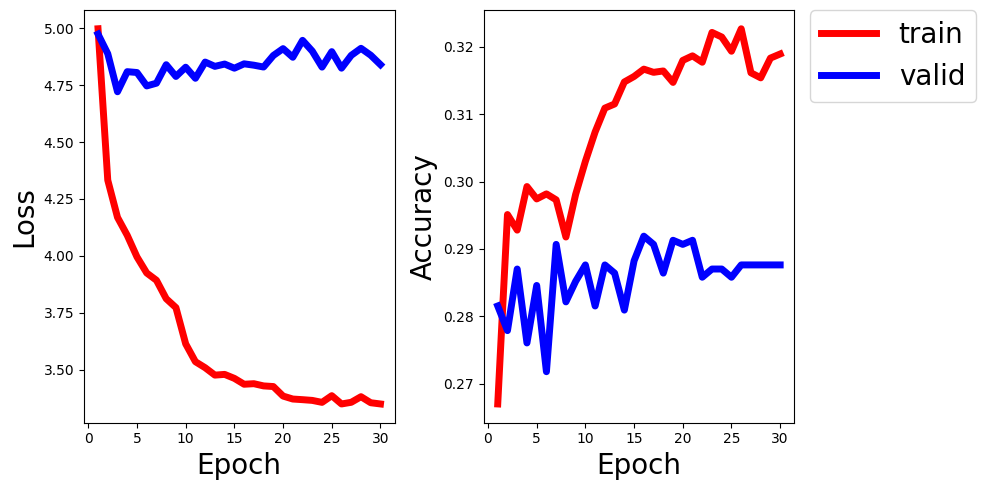

In [19]:
fig = plt.figure(figsize=(10,5))

for phase in ['train', 'valid']:

    epoch = []
    loss = []
    acc = []

    for i in range(num_epochs):

        with open('./logs/{}-log-epoch-{:02d}.txt'.format(phase, i+1), 'r') as f:
            df = csv.reader(f, delimiter='\t')
            data = list(df)

        epoch.append(float(data[0][0]))
        loss.append(float(data[0][1]))
        acc.append(float(data[0][2]))

    plt.subplot(1, 2, 1)
    if phase == 'train':
        plt.plot(epoch, loss, label = phase, color = 'red', linewidth = 5.0)
    else:
        plt.plot(epoch, loss, label = phase, color = 'blue', linewidth = 5.0)

    plt.xlabel('Epoch', fontsize = 20)
    plt.ylabel('Loss', fontsize = 20)

    plt.subplot(1, 2, 2)
    plt.tight_layout()

    if phase == 'train':
        plt.plot(epoch, acc, label = phase, color = 'red', linewidth = 5.0)
    else:
        plt.plot(epoch, acc, label = phase, color = 'blue', linewidth = 5.0)

    plt.xlabel('Epoch', fontsize = 20)
    plt.ylabel('Accuracy', fontsize = 20)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})

In [25]:
image_path = '/content/drive/MyDrive/vqa/input_dir/resize_images/test.png'
question = 'what animal is in the picture?'
saved_model = '/content/drive/MyDrive/vqa/models/best_model.pt'
max_qst_length=30

In [26]:
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


qst_vocab = load_str_list("/content/drive/MyDrive/vqa/input_dir/vocab_questions.txt")
ans_vocab = load_str_list("/content/drive/MyDrive/vqa/input_dir/vocab_answers.txt")
word2idx_dict = {w:n_w for n_w, w in enumerate(qst_vocab)}
unk2idx = word2idx_dict['<unk>'] if '<unk>' in word2idx_dict else None
qst_vocab_size = len(qst_vocab)
ans_vocab_size = len(ans_vocab)


def word2idx(w):
        if w in word2idx_dict:
            return word2idx_dict[w]
        elif unk2idx is not None:
            return unk2idx
        else:
            raise ValueError('word %s not in dictionary (while dictionary does not contain <unk>)' % w)

image = cv2.imread(image_path)
image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
image = torch.from_numpy(image).float()
image = image.to(device)
image = image.unsqueeze(dim=0)
image = image.view(1,3,224,224)
max_qst_length=30

try:
  q_list = list(question.split(" "))
except:
  q_list = list(question.split(1))
idx = 'valid'
qst2idc = np.array([word2idx('<pad>')] * max_qst_length)  # padded with '<pad>' in 'ans_vocab'
qst2idc[:len(q_list)] = [word2idx(w) for w in q_list]

question = qst2idc
question = torch.from_numpy(question).long()

question = question.to(device)
question = question.unsqueeze(dim=0)

net = torch.load(saved_model)
net = net.to(device)

net.eval()
output = model(image, question)


predicts = torch.softmax(output, 1)
probs, indices = torch.topk(predicts, k=5, dim=1)
probs = probs.squeeze()
indices = indices.squeeze()
print("predicted - probabilty")
for i in range(5):

  print("'{}' - {:.4f}".format(ans_vocab[indices[i].item()], probs[i].item()))

predicted - probabilty
'no' - 0.2501
'yes' - 0.1591
'dog' - 0.0360
'<unk>' - 0.0348
'1' - 0.0346


In [ ]:
%cd '/content/drive/MyDrive/vqa/'

/content/drive/MyDrive/vqa


In [ ]:
# Running inference on the command line
!python /content/drive/MyDrive/vqa/test.py --image_path /content/drive/MyDrive/vqa/dataset/Resized_Images/test_img.jpeg --question 'what does the sign say?' --saved_model /content/drive/MyDrive/vqa/models/best_model.pt

predicted - probabilty
'<unk>' - 0.1570
'stop' - 0.0508
'circle' - 0.0488
'apple' - 0.0449
'fall' - 0.0440
